In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [32]:
# Load dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

In [33]:
# Create a DataFrame from the feature data (X) and target data (y)
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# Display the first few rows of the DataFrame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


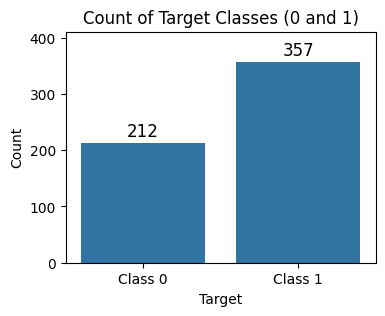

In [34]:
# Count the occurrences of each target class (0 and 1)
target_counts = df['target'].value_counts()

# Create a bar plot to visualize the counts
plt.figure(figsize=(4, 3))
ax = sns.barplot(x=target_counts.index, y=target_counts.values)

# Add some extra space above the bars
ax.set_ylim(0, target_counts.max() * 1.15)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Customize plot labels and title
plt.title('Count of Target Classes (0 and 1)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class 0', 'Class 1']);

Since the target classes (Class 0 and Class 1) are imbalanced, with a significant difference in counts, it makes sense to use the F1 score for scoring in the grid search.

In [35]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# Initialize models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()

In [38]:
# Define parameter grids for GridSearch
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [39]:
# Perform Grid Search for each model
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)

# Fit models with the best parameters
grid_search_dt.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_knn = grid_search_knn.best_estimator_

In [40]:
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best parameters for K-Nearest Neighbors:", grid_search_knn.best_params_)

Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for K-Nearest Neighbors: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [41]:
# Cross-validation to evaluate performance metrics
def evaluate_model(model, X, y, scoring):
    return cross_val_score(model, X, y, cv=5, scoring=scoring)

In [42]:
# Custom scorer for specificity (True Negative Rate)
from sklearn.metrics import make_scorer, recall_score

def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

specificity = make_scorer(specificity_score)

# Scoring metrics dictionary
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'specificity': specificity,  # Custom specificity scorer
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}


In [43]:
# Evaluate models with 5-fold CV for multiple metrics
results = {}

for model_name, model in zip(['Decision Tree', 'Random Forest', 'KNN'], [best_dt, best_rf, best_knn]):
    results[model_name] = {}
    for metric_name, metric in scoring_metrics.items():
        results[model_name][metric_name] = evaluate_model(model, X_train, y_train, metric)

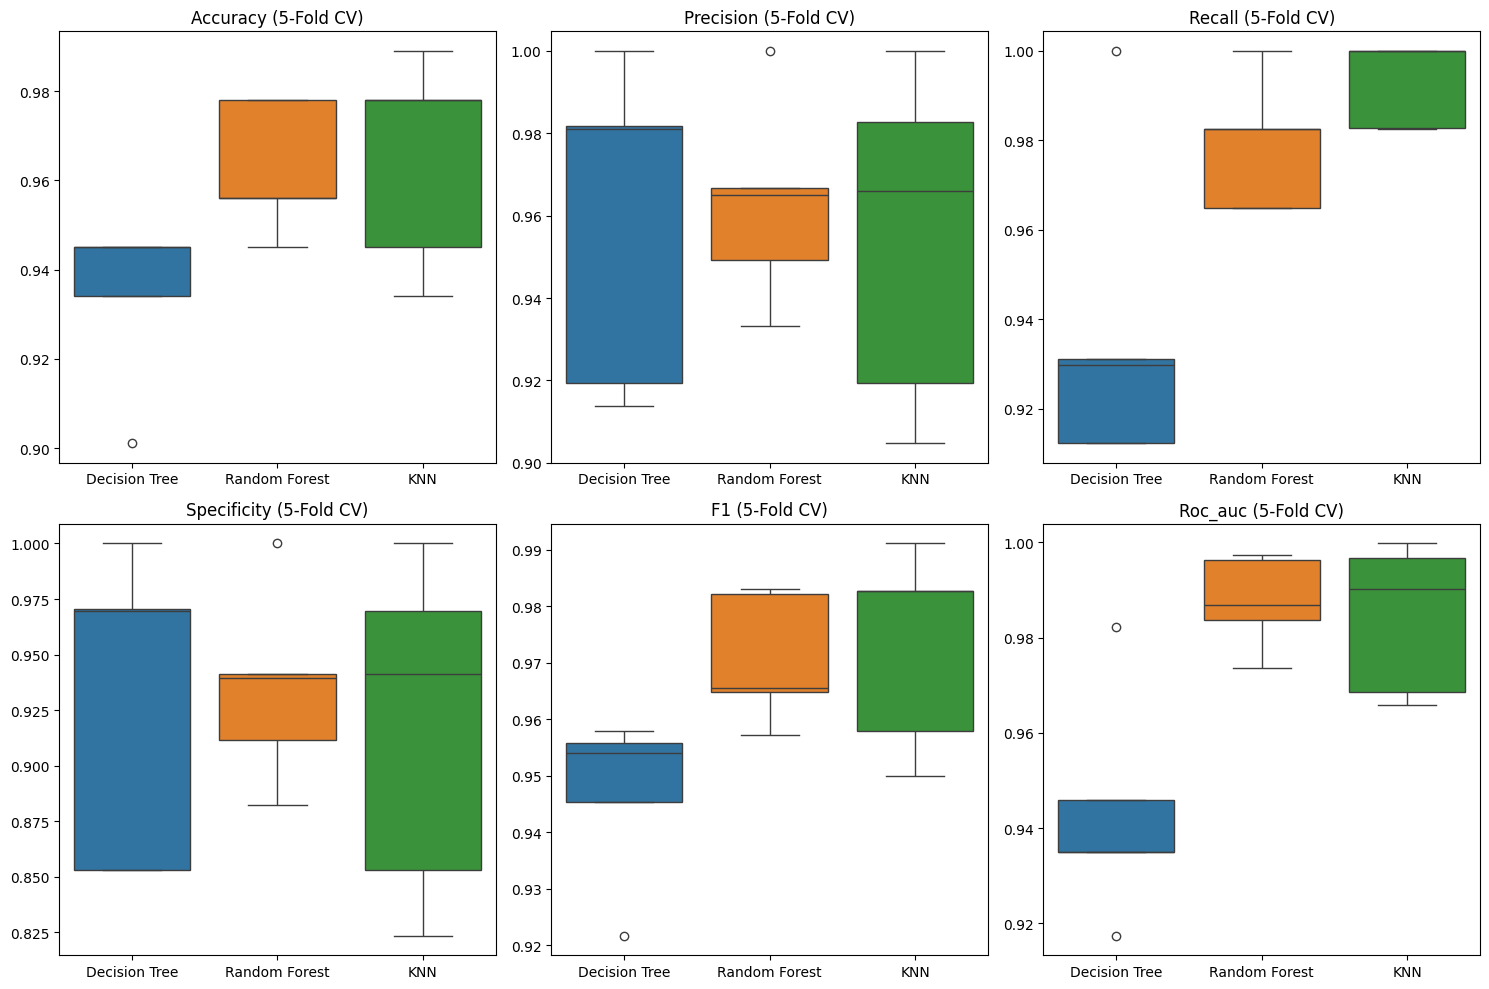

In [44]:
# Create boxplots 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, metric in enumerate(scoring_metrics):
    data = [results[model][metric] for model in results]
    sns.boxplot(data=data, ax=axes[idx])
    axes[idx].set_title(f'{metric.capitalize()} (5-Fold CV)')
    
    # Set ticks and tick labels
    axes[idx].set_xticks(range(len(results)))
    axes[idx].set_xticklabels(results.keys())
    
plt.tight_layout()

Decision Tree (AUC = 0.94)
Random Forest (AUC = 0.96)
KNN (AUC = 0.96)


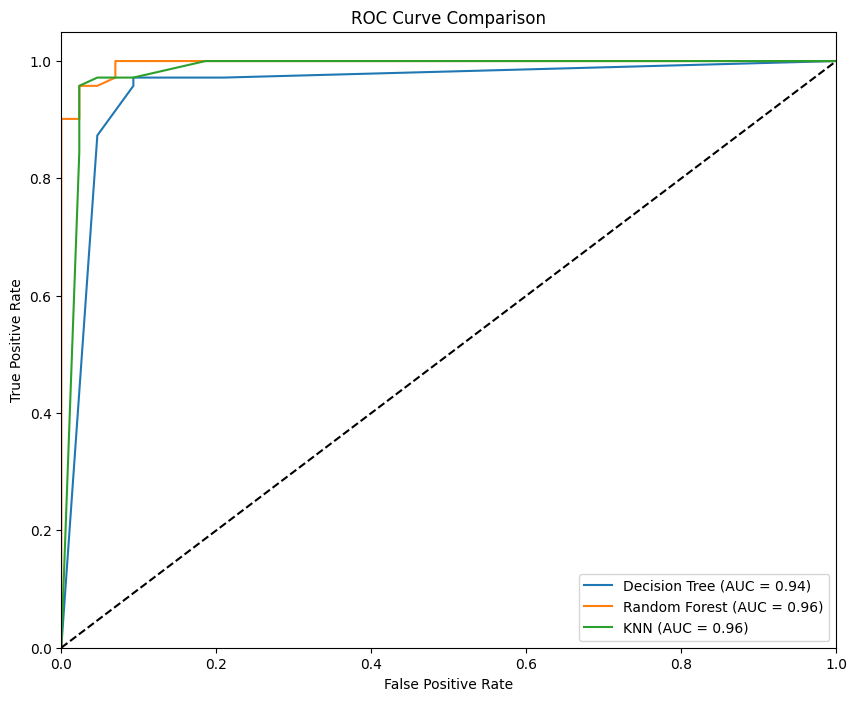

In [45]:
# Evaluate models on the test set and plot ROC curves
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, model.predict(X_test))
        print(f'{model_name} (AUC = {auc:.2f})')
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")

# Plot ROC curves for the models
best_models = {'Decision Tree': best_dt, 'Random Forest': best_rf, 'KNN': best_knn}
plot_roc_curve(best_models, X_test, y_test)


### The best model

The model that performed best overall was the **Random Forest**. This model consistently achieved high scores across key metrics, including accuracy, precision, recall, F1 score, and ROC AUC. 

The second best model is **KNN**. It has great ROC AUC and F1 scores, but shows slightly more variability in specificity, meaning it occasionally misclassified negative cases compared to the more consistent performance of the Random Forest.

### Impact of hyperparameter tuning

Hyperparameter tuning played a significant role in optimizing each model's performance by fine-tuning parameters. Using a grid search with cross-validation allowed for robust evaluation across multiple folds, *ensuring that the selected hyperparameters were generalizable and not overly biased by specific data splits*.

## Evaluation of the assignment

1. Properly loads and standardizes the data (10 points).

2. Justifies why the F1 score is the preferred metric for Grid Search due to class imbalance (10 points).

3. Conducts Grid Search for each model to optimize hyperparameters (20 points).

4. Implements a custom method for calculating specificity (5 points).

5. Accurately evaluates models using 5-fold cross-validation across six metrics (15 points).

6. Creates six boxplots to visualize cross-validation results for each metric (15 points).

7. Generates ROC curves for three models to assess classification performance (10 points).

8. Provides a rationale for selecting Random Forest as the best model (10 points, 8 points if selecting KNN, 0 points for Decision Tree).

9. Discusses how hyperparameter tuning impacts model performance (5 points).